In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_confusion_matrix

In [3]:
df = pd.read_csv('crop_identify_v1.csv')
df_uto = df.copy(deep = True)
pd.set_option('display.max_columns', None)

In [4]:
# data preprocess

df_uto = df_uto.dropna()
df_uto = df_uto[pd.to_numeric(df_uto['B1_spring'], downcast='float',errors='coerce').notnull()]
df_uto = df_uto[(df_uto['CLASS1_spring'] == df_uto['CLASS1_summer']) & (df_uto['CLASS1_summer'] == df_uto['CLASS1_winter'])]

df_uto.shape

(68607, 37)

# Draw the bar of crop type count & boxplot of bands

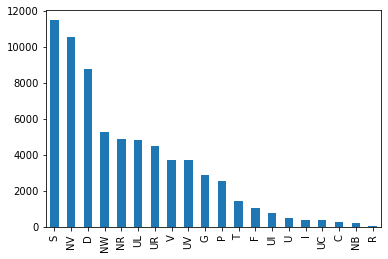

In [5]:
fig, ax = plt.subplots()
ax = df_uto['CLASS1_spring'].value_counts().plot(kind = 'bar')
plt.show()

In [175]:
# define a number to use for "unbiasing" the classes

def row_selection (df, n = 2500):

    df_uto_2 = pd.DataFrame()     # create the placeholder df

    for crop in df['CLASS1_spring'].unique():

        df_class = df[df['CLASS1_spring'] == crop]
        length = len(df_class)


        # put more when length is less than n
        if length <= n:
            times = math.ceil(n / length)    # round up

            # copy the class data by times
            df_class_concat = pd.concat([df_class] * times)

            # randomly sample the dataset down to 2500 rows
            df_class_concat = df_class_concat.sample(n, random_state = 42)

            # concat this dataset to the placeholder
            df_uto_2 = df_uto_2.append(df_class_concat)

            #print (len(df_class_concat))


        # delete when length is more than n
        if length > n:

            df_class = df_class.sample(n, random_state = 42)
            df_uto_2 = df_uto_2.append(df_class)

    # reset the index    
    df_uto_2 = df_uto_2.reset_index()

    # drop "system:index"
    df_uto_2.drop(['system:index', 'index', 'CLASS1_winter', 'CLASS1_summer'], axis = 1, inplace=True)
    
    return df_uto_2


In [176]:
df_uto = row_selection(df_uto, 2500)
df_uto.shape

(50000, 34)

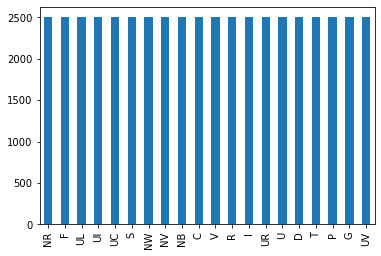

In [130]:
fig, ax = plt.subplots()
ax = df_uto['CLASS1_spring'].value_counts().plot(kind = 'bar')
plt.show()

In [150]:
df_uto.shape

(50000, 34)

# re-categarize vegetions
bring catogory size down to ['G','R','F','P','T','C']


In [153]:
# df_class_target = df_float.loc[df_float['CLASS1_spring'].isin(['G','R','F','P','T','D','C','V'])]
# # df_class_new.CLASS1_spring
# df_class_target = df_class_target.set_index('system:index')
# df_class_target

In [154]:
# df_class_target['CLASS1_spring'].unique()

In [6]:
column_list = df_uto.columns
column_list

# column_uto = ['B1_spring', 'B10_spring', 'B11_spring', 'B2_spring', 'B3_spring',
#        'B4_spring', 'B5_spring', 'B6_spring', 'B7_spring', 'B8_spring',
#        'B9_spring', 'B1_winter', 'B10-winter', 'B11_winter',
#        'B2_winter', 'B3_winter', 'B4_winter', 'B5_winter', 'B6_winter',
#        'B7_winter', 'B8_winter', 'B9_winter', 'B1_summer',
#        'B10_summer', 'B11_summer', 'B2_summer', 'B3_summer', 'B4_summer',
#        'B5_summer', 'B6_summer', 'B7_summer', 'B8_summer', 'B9_summer']

Index(['system:index', 'B1_spring', 'B10_spring', 'B11_spring', 'B2_spring',
       'B3_spring', 'B4_spring', 'B5_spring', 'B6_spring', 'B7_spring',
       'B8_spring', 'B9_spring', 'CLASS1_spring', 'B1_winter', 'B10-winter',
       'B11_winter', 'B2_winter', 'B3_winter', 'B4_winter', 'B5_winter',
       'B6_winter', 'B7_winter', 'B8_winter', 'B9_winter', 'CLASS1_winter',
       'B1_summer', 'B10_summer', 'B11_summer', 'B2_summer', 'B3_summer',
       'B4_summer', 'B5_summer', 'B6_summer', 'B7_summer', 'B8_summer',
       'B9_summer', 'CLASS1_summer'],
      dtype='object')

In [7]:
# convert string to float format, except 'class' columns and index

for col in [ 'B1_spring', 'B10_spring', 'B11_spring', 'B2_spring',
       'B3_spring', 'B4_spring', 'B5_spring', 'B6_spring', 'B7_spring',
       'B8_spring', 'B9_spring', 'B1_winter', 'B10-winter',
       'B11_winter', 'B2_winter', 'B3_winter', 'B4_winter', 'B5_winter',
       'B6_winter', 'B7_winter', 'B8_winter', 'B9_winter', 
       'B1_summer', 'B10_summer', 'B11_summer', 'B2_summer', 'B3_summer',
       'B4_summer', 'B5_summer', 'B6_summer', 'B7_summer', 'B8_summer',
       'B9_summer']:
    nonan_to_num = pd.to_numeric(df_uto[col],downcast='float',errors='coerce')
    df_uto[col] = nonan_to_num
    
df_uto = df_uto.dropna()

In [8]:
df_uto.shape

(68607, 37)


# calculate vegetation index

In [10]:
df_uto['NDVI_spring'] = (df_uto.B5_spring - df_uto.B4_spring) / (df_uto.B5_spring + df_uto.B4_spring)
df_uto['NDVI_winter'] = (df_uto.B5_winter - df_uto.B4_winter) / (df_uto.B5_winter + df_uto.B4_winter)
df_uto['NDVI_summer'] = (df_uto.B5_summer - df_uto.B4_summer) / (df_uto.B5_summer + df_uto.B4_summer)

df_uto['EVI_spring'] = 2.5*((df_uto.B5_spring - df_uto.B4_spring) / (df_uto.B5_spring + 6*df_uto.B4_spring-7.5*df_uto.B2_spring+1))
df_uto['EVI_winter'] = 2.5*((df_uto.B5_winter - df_uto.B4_winter) / (df_uto.B5_winter + 6*df_uto.B4_winter-7.5*df_uto.B2_winter +1))
df_uto['EVI_summer'] = 2.5*((df_uto.B5_summer - df_uto.B4_summer) / (df_uto.B5_summer + 6*df_uto.B4_summer-7.5*df_uto.B2_summer +1))

df_uto['LSWI_spring'] = (df_uto.B5_spring - df_uto.B6_spring) / (df_uto.B5_spring + df_uto.B6_spring)
df_uto['LSWI_winter'] = (df_uto.B5_winter - df_uto.B6_winter) / (df_uto.B5_winter + df_uto.B6_winter)
df_uto['LSWI_summer'] = (df_uto.B5_summer - df_uto.B6_summer) / (df_uto.B5_summer + df_uto.B6_summer)

df_uto['NDSI_spring'] = (df_uto.B2_spring - df_uto.B5_spring) / (df_uto.B2_spring + df_uto.B5_spring)
df_uto['NDSI_winter'] = (df_uto.B2_winter - df_uto.B5_winter) / (df_uto.B2_winter + df_uto.B5_winter)
df_uto['NDSI_summer'] = (df_uto.B2_summer - df_uto.B5_summer) / (df_uto.B2_summer + df_uto.B5_summer)

df_uto['MSR_spring'] = (df_uto.B5_spring / df_uto.B4_spring -1) / ((df_uto.B5_spring / df_uto.B4_spring).pow(0.5)+1)
df_uto['MSR_winter'] = (df_uto.B5_winter / df_uto.B4_winter -1) / ((df_uto.B5_winter / df_uto.B4_winter).pow(0.5)+1)
df_uto['MSR_summer'] = (df_uto.B5_summer / df_uto.B4_summer -1) / ((df_uto.B5_summer / df_uto.B4_summer).pow(0.5)+1)

df_uto['SAVI_spring'] = (1+0.5)*(df_uto.B5_spring - df_uto.B4_spring)/ (df_uto.B5_spring + df_uto.B4_spring +0.5)
df_uto['SAVI_winter'] = (1+0.5)*(df_uto.B5_winter - df_uto.B4_winter)/ (df_uto.B5_winter + df_uto.B4_winter +0.5)
df_uto['SAVI_summer'] = (1+0.5)*(df_uto.B5_summer - df_uto.B4_summer)/ (df_uto.B5_summer + df_uto.B4_summer +0.5)

df_uto['MSAVI_spring'] = 0.5 * 2 * (df_uto.B5_spring + 1)- ((2*df_uto.B5_spring + 1)**2 - 8*(df_uto.B5_spring - df_uto.B4_spring)).pow(0.5)
df_uto['MSAVI_winter'] = 0.5 * 2 * (df_uto.B5_winter + 1)- ((2*df_uto.B5_winter + 1)**2 - 8*(df_uto.B5_winter - df_uto.B4_winter)).pow(0.5)
df_uto['MSAVI_summer'] = 0.5 * 2 * (df_uto.B5_summer + 1)- ((2*df_uto.B5_summer + 1)**2 - 8*(df_uto.B5_summer - df_uto.B4_summer)).pow(0.5)


df_uto['MCARI_spring'] = ((df_uto.B8_spring - df_uto.B4_spring) - 0.2*(df_uto.B8_spring - df_uto.B3_spring))*(df_uto.B8_spring / df_uto.B4_spring)
df_uto['MCARI_winter'] = ((df_uto.B8_winter - df_uto.B4_winter) - 0.2*(df_uto.B8_winter - df_uto.B3_winter))*(df_uto.B8_winter / df_uto.B4_winter)
df_uto['MCARI_summer'] = ((df_uto.B8_summer - df_uto.B4_summer) - 0.2*(df_uto.B8_summer - df_uto.B3_summer))*(df_uto.B8_summer / df_uto.B4_summer)


df_uto['TVI_spring'] = ((df_uto.B5_spring - df_uto.B4_spring) / (df_uto.B5_spring + df_uto.B4_spring) + 0.05).pow(0.5)
df_uto['TVI_winter'] = ((df_uto.B5_winter - df_uto.B4_winter) / (df_uto.B5_winter + df_uto.B4_winter) + 0.05).pow(0.5)
df_uto['TVI_summer'] = ((df_uto.B5_summer - df_uto.B4_summer) / (df_uto.B5_summer + df_uto.B4_summer) + 0.05).pow(0.5)

df_uto

,system:index,B1_spring,B10_spring,B11_spring,B2_spring,B3_spring,B4_spring,B5_spring,B6_spring,B7_spring,B8_spring,B9_spring,CLASS1_spring,B1_winter,B10-winter,B11_winter,B2_winter,B3_winter,B4_winter,B5_winter,B6_winter,B7_winter,B8_winter,B9_winter,CLASS1_winter,B1_summer,B10_summer,B11_summer,B2_summer,B3_summer,B4_summer,B5_summer,B6_summer,B7_summer,B8_summer,B9_summer,CLASS1_summer,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,MSR_winter,MSR_summer,SAVI_spring,SAVI_winter,SAVI_summer,MSAVI_spring,MSAVI_winter,MSAVI_summer,MCARI_spring,MCARI_winter,MCARI_summer,TVI_spring,TVI_winter,TVI_summer
0,575,0.137870,296.919312,295.006256,0.121318,0.114790,0.116047,0.255466,0.219632,0.154827,0.120979,0.004193,NR,0.136201,291.873779,291.197937,0.115085,0.094274,0.098081,0.178297,0.166989,0.116143,0.095505,0.001935,NR,0.148203,308.010590,305.756622,0.134168,0.129715,0.145501,0.288045,0.249864,0.165475,0.129982,0.001319,NR,0.375275,0.290240,0.328786,0.334545,0.221924,0.308592,0.075424,0.032750,0.070980,-0.356033,-0.215459,-0.364455,0.483714,0.348278,0.407010,0.239961,0.154981,0.229036,0.174929,0.083482,0.128861,0.003852,-0.002749,-0.013912,0.652131,0.583301,0.615456
1,0000000000000000d69e,0.141525,299.978882,297.410858,0.126581,0.117719,0.123802,0.240773,0.242453,0.176007,0.116693,0.005776,NR,0.134013,291.008423,290.416351,0.111528,0.089637,0.091366,0.177057,0.168947,0.116412,0.090258,0.001602,NR,0.143830,306.160645,304.078094,0.127054,0.118999,0.122309,0.291530,0.232840,0.155406,0.120025,0.001205,NR,0.320843,0.319238,0.408905,0.282751,0.241032,0.394461,-0.003475,0.023442,0.111924,-0.310851,-0.227069,-0.392935,0.394570,0.392079,0.543876,0.202940,0.167273,0.277764,0.118628,0.105564,0.218073,-0.006507,-0.001217,-0.002443,0.608969,0.607649,0.677426
2,000000000000000007b7,0.139689,297.194397,295.106140,0.124307,0.122132,0.127728,0.290701,0.241713,0.169333,0.124269,0.004226,NR,0.140897,291.086029,290.456635,0.121447,0.107084,0.118545,0.205443,0.202068,0.148261,0.112975,0.002491,NR,0.150206,308.236115,305.889618,0.136525,0.134937,0.153679,0.290604,0.273791,0.202683,0.140313,0.001305,NR,0.389487,0.268216,0.308193,0.362237,0.215982,0.287961,0.092012,0.008282,0.029789,-0.400941,-0.256954,-0.360733,0.508619,0.316452,0.375129,0.266171,0.158192,0.217506,0.196603,0.067282,0.105353,-0.003782,-0.006431,-0.013185,0.662938,0.564106,0.598492
3,0000000000000000d550,0.139958,301.539093,298.730621,0.122185,0.112358,0.111912,0.253542,0.235656,0.175262,0.108910,0.005985,NR,0.130307,290.457275,289.809570,0.106631,0.083082,0.077389,0.178852,0.157212,0.105869,0.076255,0.001384,NR,0.139495,304.307983,302.590668,0.120299,0.111613,0.104833,0.320409,0.220294,0.143512,0.104794,0.001047,NR,0.387545,0.395969,0.506950,0.351047,0.300739,0.514666,0.036562,0.064395,0.185157,-0.349607,-0.252979,-0.454066,0.505173,0.520227,0.748252,0.245472,0.201253,0.349492,0.186648,0.163149,0.336705,-0.002251,0.000229,0.001325,0.661472,0.667809,0.746291
4,0000000000000000a7ab,0.174291,299.341827,296.964478,0.162792,0.153956,0.169576,0.260021,0.314058,0.257832,0.158310,0.007199,F,0.156139,291.498016,290.941162,0.138696,0.119764,0.132346,0.197404,0.268908,0.212049,0.122958,0.001143,F,0.158954,303.126740,301.695099,0.144171,0.132493,0.145624,0.233070,0.300166,0.230131,0.136236,0.001224,F,0.210534,0.197296,0.230916,0.214013,0.170980,0.213174,-0.094129,-0.153338,-0.125828,-0.229956,-0.174675,-0.235657,0.238288,0.221302,0.265108,0.145942,0.117611,0.149278,0.000272,0.003661,0.028913,-0.011330,-0.009316,-0.009483,0.510425,0.497289,0.530015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74552,00010000000000003f26,0.157493,295.759796,293.721954,0.143518,0.137176,0.136342,0.261229,0.

In [161]:
# df_uto_G = df_uto.loc[df_uto['CLASS1_spring'].isin(["G"])]


,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,SAVI_spring,MSAVI_spring,MCARI_spring,TVI_spring,MSR_winter,MSR_summer,SAVI_winter,SAVI_summer,MSAVI_winter,MSAVI_summer,MCARI_winter,MCARI_summer,TVI_winter,TVI_summer
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,0.630770,0.214485,0.443851,0.713103,0.172628,0.486277,0.356039,-0.076563,0.165600,-0.534353,-0.165647,-0.427392,1.233299,0.458910,0.534169,0.015655,0.818661,0.254632,0.752284,0.121186,0.322041,0.026800,0.284359,-0.006789,-0.003273,0.509194,0.685396
std,0.152226,0.084927,0.215838,0.224981,0.092864,0.283768,0.175252,0.095430,0.229444,0.122633,0.113144,0.134706,0.487830,0.133013,0.220107,0.010570,0.102799,0.159990,0.532795,0.060451,0.160861,0.082642,0.283335,0.007558,0.019321,0.072174,0.155214
min,0.041971,-0.002819,0.115517,0.017222,-0.000943,0.111260,-0.240753,-0.370577,-0.250734,-0.721153,-0.612822,-0.690949,0.042890,0.011019,-0.082825,-0.029659,0.303267,-0.002815,0.123035,-0.000561,0.078594,-0.115601,-0.124120,-0.052529,-0.057270,0.217213,0.406838
25%,0.562535,0.167465,0.245729,0.582480,0.125227,0.234065,0.271723,-0.131288,-0.034070,-0.618015,-0.228549,-0.556791,0.889919,0.385784,0.403596,0.009852,0.782646,0.184188,0.285133,0.087063,0.180882,-0.012419,0.024309,-0.011395,-0.019749,0.466331,0.543809
50%,0.674737,0.197486,0.355926,0.736969,0.155502,0.349727,0.404324,-0.093017,0.068874,-0.561804,-0.180349,-0.421855,1.269112,0.476815,0.568434,0.018254,0.851315,0.221544,0.450942,0.111845,0.262561,0.006844,0.156337,-0.007130,-0.004591,0.497480,0.637123
75%,0.742844,0.233984,0.685530,0.873872,0.192357,0.791316,0.491410,-0.040495,0.407898,-0.485415,-0.103693,-0.330009,1.603343,0.554184,0.702307,0.023469,0.890418,0.269217,1.315149,0.138289,0.491670,0.034699,0.592838,-0.002357,0.015898,0.532901,0.857631
max,0.846786,0.776178,0.800881,1.168279,1.002835,1.136087,0.592300,0.720568,0.570146,0.265327,0.417288,-0.059893,2.471839,0.718992,0.936947,0.035895,0.946988,1.817030,2.007368,0.568585,0.684007,0.730463,0.845038,0.027851,0.034627,0.908943,0.922432


In [11]:
# classify class into 's' and 'not s'
df_uto =df_uto.dropna()
df_uto_s = df_uto.copy(deep = True)

# df_uto_s.loc[df_uto["CLASS1_summer"] != "G", "CLASS1_summer"] = 'not_g'
# df_uto_s

In [181]:
# check the number of 'S' and 'not_s'

df_uto_s.loc[df_uto_s['CLASS1_summer']== 'not_g']

KeyError: 'CLASS1_summer'

In [12]:
df_class_target = df_uto_s.loc[df_uto_s['CLASS1_spring'].isin(['G','R','F','P','T','C'])]
df_class_target

,system:index,B1_spring,B10_spring,B11_spring,B2_spring,B3_spring,B4_spring,B5_spring,B6_spring,B7_spring,B8_spring,B9_spring,CLASS1_spring,B1_winter,B10-winter,B11_winter,B2_winter,B3_winter,B4_winter,B5_winter,B6_winter,B7_winter,B8_winter,B9_winter,CLASS1_winter,B1_summer,B10_summer,B11_summer,B2_summer,B3_summer,B4_summer,B5_summer,B6_summer,B7_summer,B8_summer,B9_summer,CLASS1_summer,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,MSR_winter,MSR_summer,SAVI_spring,SAVI_winter,SAVI_summer,MSAVI_spring,MSAVI_winter,MSAVI_summer,MCARI_spring,MCARI_winter,MCARI_summer,TVI_spring,TVI_winter,TVI_summer
4,0000000000000000a7ab,0.174291,299.341827,296.964478,0.162792,0.153956,0.169576,0.260021,0.314058,0.257832,0.158310,0.007199,F,0.156139,291.498016,290.941162,0.138696,0.119764,0.132346,0.197404,0.268908,0.212049,0.122958,0.001143,F,0.158954,303.126740,301.695099,0.144171,0.132493,0.145624,0.233070,0.300166,0.230131,0.136236,0.001224,F,0.210534,0.197296,0.230916,0.214013,0.170980,0.213174,-0.094129,-0.153338,-0.125828,-0.229956,-0.174675,-0.235657,0.238288,0.221302,0.265108,0.145942,0.117611,0.149278,0.000272,0.003661,0.028913,-0.011330,-0.009316,-0.009483,0.510425,0.497289,0.530015
5,0000000000000000a8b5,0.157427,301.605499,298.911774,0.141596,0.125611,0.131975,0.207725,0.245464,0.201440,0.128418,0.007765,F,0.142115,291.878265,291.292786,0.120521,0.094496,0.096489,0.139416,0.189735,0.151276,0.095479,0.001039,F,0.142383,302.269073,300.907867,0.122151,0.100126,0.101707,0.163019,0.172709,0.112946,0.099810,0.001171,F,0.222991,0.181968,0.231603,0.201977,0.131768,0.178827,-0.083274,-0.152876,-0.028863,-0.189307,-0.072691,-0.143312,0.254581,0.202036,0.266026,0.135316,0.087498,0.120261,0.025567,0.002756,0.037015,-0.004007,-0.001194,-0.001800,0.522485,0.481630,0.530663
6,0000000000000000a8b8,0.168777,300.750458,298.205933,0.155936,0.145052,0.157183,0.242233,0.290206,0.236275,0.148758,0.007238,F,0.150223,291.505402,290.978394,0.131565,0.110931,0.120835,0.185267,0.245966,0.188893,0.113947,0.000976,F,0.142736,302.135986,300.872070,0.123408,0.103626,0.107769,0.177228,0.208733,0.139815,0.104511,0.001166,F,0.212935,0.210492,0.243717,0.209315,0.174416,0.193309,-0.090101,-0.140757,-0.081628,-0.216733,-0.169497,-0.179021,0.241404,0.238233,0.282385,0.141841,0.119895,0.132724,0.008036,0.017830,0.046351,-0.008675,-0.007065,-0.003331,0.512772,0.510384,0.541956
7,00000000000000005afd,0.133703,296.563812,294.972321,0.116205,0.118793,0.104201,0.387968,0.222333,0.136868,0.109767,0.003128,G,0.148079,291.186798,290.849060,0.128614,0.113099,0.121724,0.172940,0.219989,0.181171,0.114037,0.001239,G,0.145854,307.062012,304.706665,0.130637,0.127903,0.141770,0.287719,0.243681,0.165689,0.130560,0.001148,G,0.576565,0.173810,0.339820,0.621404,0.136403,0.314936,0.271397,-0.119738,0.082873,-0.539028,-0.146992,-0.375475,0.929580,0.191952,0.424597,0.429011,0.096674,0.235531,0.447856,-0.010981,0.141240,0.007766,-0.007378,-0.010813,0.791559,0.473086,0.624356
8,00000000000000005bc2,0.129519,295.394073,293.930420,0.110509,0.112607,0.092614,0.407458,0.203739,0.116085,0.102388,0.003120,G,0.146330,291.497711,291.154266,0.126386,0.109326,0.117201,0.161842,0.205539,0.169000,0.110224,0.001229,G,0.140792,305.151428,303.079987,0.124598,0.124675,0.134672,0.336588,0.222701,0.133007,0.125970,0.001166,G,0.629596,0.159978,0.428459,0.693901,0.121682,0.417133,0.333312,-0.118942,0.203629,-0.573296,-0.123014,-0.459664,1.097500,0.175112,0.580921,0.472231,0.085953,0.311836,0.527020,-0.019265,0.248382,0.013065,-0.006731,-0.008382,0.824376,0.458233,0.691707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61931,0001000000000000448c,0.125822,293.313995,291.521393,0.104265,0.097974,0.069

In [120]:
# normalize vegetation index

# from sklearn import preprocessing

# sc =  preprocessing.normalize(df_uto_G)
# df_uto_G_v2 = pd.DataFrame(sc, columns = df_uto_G_column)

# df_uto_G_v2

,B1_spring,B10_spring,B11_spring,B2_spring,B3_spring,B4_spring,B5_spring,B6_spring,B7_spring,B8_spring,B9_spring,B1_winter,B10-winter,B11_winter,B2_winter,B3_winter,B4_winter,B5_winter,B6_winter,B7_winter,B8_winter,B9_winter,B1_summer,B10_summer,B11_summer,B2_summer,B3_summer,B4_summer,B5_summer,B6_summer,B7_summer,B8_summer,B9_summer,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSAVI_spring,MCARI_spring,TVI_spring
0,0.000183,0.406092,0.403913,0.000159,0.000163,0.000143,0.000531,0.000304,0.000187,0.000150,0.000004,0.000203,0.398729,0.398267,0.000176,0.000155,0.000167,0.000237,0.000301,0.000248,0.000156,0.000002,0.000200,0.420468,0.417242,0.000179,0.000175,0.000194,0.000394,0.000334,0.000227,0.000179,0.000002,0.000790,0.000238,0.000465,0.000851,0.000187,0.000431,0.000372,-0.000164,0.000113,-0.000738,-0.000201,-0.000514,0.058755,1.063381e-05,0.001257
1,0.000178,0.405606,0.403596,0.000152,0.000155,0.000127,0.000559,0.000280,0.000159,0.000141,0.000004,0.000201,0.400256,0.399784,0.000174,0.000150,0.000161,0.000222,0.000282,0.000232,0.000151,0.000002,0.000193,0.419004,0.416159,0.000171,0.000171,0.000185,0.000462,0.000306,0.000183,0.000173,0.000002,0.000864,0.000220,0.000588,0.000953,0.000167,0.000573,0.000458,-0.000163,0.000280,-0.000787,-0.000169,-0.000631,0.061648,1.793894e-05,0.001903
2,0.000192,0.406017,0.403895,0.000170,0.000173,0.000157,0.000541,0.000319,0.000211,0.000153,0.000004,0.000206,0.400316,0.399838,0.000181,0.000161,0.000175,0.000245,0.000307,0.000254,0.000160,0.000002,0.000203,0.418596,0.416027,0.000184,0.000183,0.000201,0.000431,0.000341,0.000228,0.000184,0.000002,0.000756,0.000228,0.000500,0.000835,0.000182,0.000484,0.000354,-0.000155,0.000160,-0.000716,-0.000207,-0.000552,0.059919,3.452341e-07,0.000437
3,0.000178,0.406842,0.404779,0.000153,0.000157,0.000135,0.000550,0.000291,0.000164,0.000145,0.000004,0.000202,0.400891,0.400328,0.000176,0.000154,0.000168,0.000230,0.000291,0.000239,0.000157,0.000002,0.000190,0.417133,0.414692,0.000168,0.000169,0.000184,0.000510,0.000297,0.000161,0.000171,0.000002,0.000831,0.000214,0.000646,0.000895,0.000165,0.000647,0.000423,-0.000161,0.000363,-0.000776,-0.000185,-0.000694,0.060668,1.239340e-05,0.001410
4,0.000178,0.406763,0.404651,0.000154,0.000157,0.000144,0.000517,0.000288,0.000164,0.000148,0.000004,0.000201,0.400881,0.400373,0.000174,0.000155,0.000171,0.000233,0.000286,0.000235,0.000158,0.000002,0.000189,0.417446,0.415033,0.000168,0.000172,0.000194,0.000515,0.000309,0.000164,0.000176,0.000002,0.000778,0.000212,0.000622,0.000802,0.000161,0.000614,0.000391,-0.000140,0.000343,-0.000746,-0.000200,-0.000699,0.057260,6.177822e-06,0.000784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,0.000173,0.402604,0.400144,0.000143,0.000134,0.000096,0.000548,0.000218,0.000118,0.000116,0.000008,0.000197,0.398065,0.397717,0.000170,0.000143,0.000156,0.000257,0.000347,0.000283,0.000146,0.000001,0.000221,0.424492,0.421106,0.000205,0.000202,0.000240,0.000407,0.000521,0.000408,0.000213,0.000002,0.000965,0.000336,0.000356,0.001092,0.000270,0.000343,0.000591,-0.000203,-0.000168,-0.000804,-0.000279,-0.000453,0.060199,2.858167e-05,0.002744
2861,0.000174,0.404874,0.402280,0.000145,0.000134,0.000109,0.000468,0.000232,0.000139,0.000122,0.000008,0.000194,0.398195,0.397948,0.000169,0.000146,0.000164,0.000257,0.000344,0.000282,0.000150,0.000001,0.000216,0.422680,0.419510,0.000202,0.000207,0.000249,0.000494,0.000469,0.000299,0.000219,0.000002,0.000853,0.000303,0.000453,0.000878,0.000238,0.000457,0.000462,-0.000199,0.000035,-0.000721,-0.000281,-0.000576,0.051677,1.696092e-05,0.001768
2862,0.000173,0.403507,0.401038,0.000143,0.000128,0.000098,0.000501,0.000213,0.000120,0.000114,0.000008,0.000195,0.398669,0.398349,0.000171,0.000146,0.000160,0.000238,0.000308,0.000253,0.0

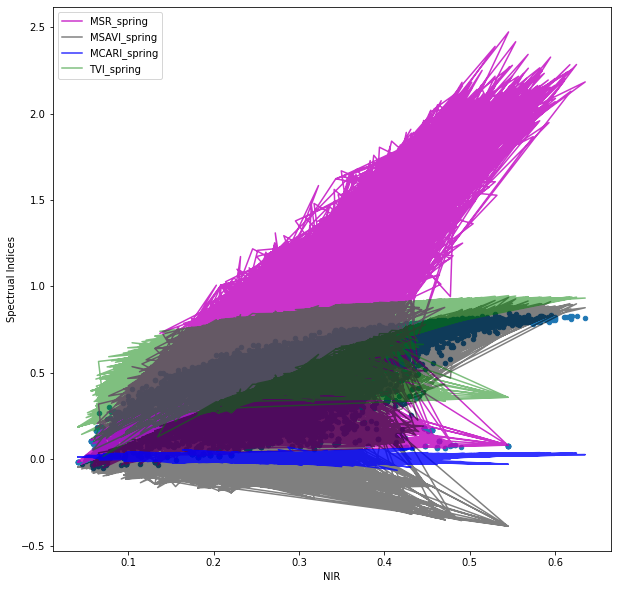

In [158]:
# Sensitivity analysis


ax = df_uto.plot(kind='scatter', x='B5_spring', y='NDVI_spring',figsize=(10,10))
df_uto.plot(x="B5_spring",y="MSR_spring", color="m", ax=ax,alpha=0.8)
df_uto.plot(x="B5_spring",y="MSAVI_spring", color="k", ax=ax, alpha=0.5)
df_uto.plot(x="B5_spring",y="MCARI_spring", color="b", ax=ax, alpha=0.8)
df_uto.plot(x="B5_spring",y="TVI_spring", color="g", ax=ax,alpha=0.5)

ax.set_xlabel("NIR")
ax.set_ylabel("Spectrual Indices")
plt.show()

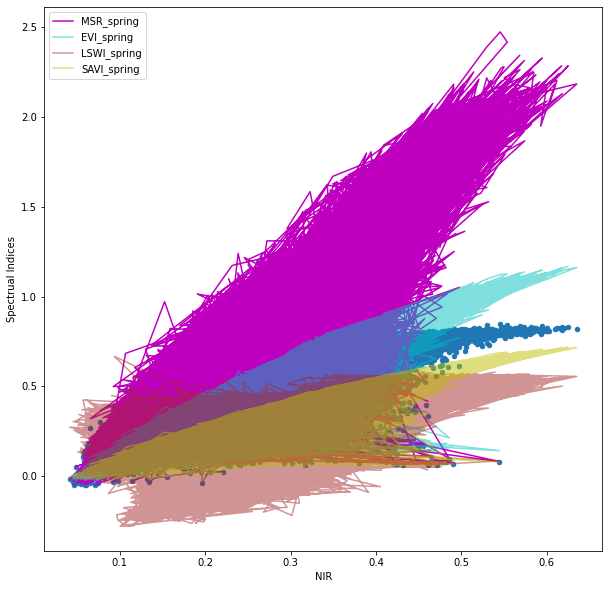

In [245]:
ax = df_uto.plot(kind='scatter', x='B5_spring', y='NDVI_spring',figsize=(10,10))
df_uto.plot(x="B5_spring",y="MSR_spring", color="m", ax=ax)
df_uto.plot(x="B5_spring",y="EVI_spring", color="c", ax=ax, alpha=0.5)
df_uto.plot(x="B5_spring",y="LSWI_spring", color="brown", ax=ax, alpha=0.5)
df_uto.plot(x="B5_spring",y="SAVI_spring", color="y", ax=ax, alpha=0.5)


ax.set_xlabel("NIR")
ax.set_ylabel("Spectrual Indices")
plt.show()

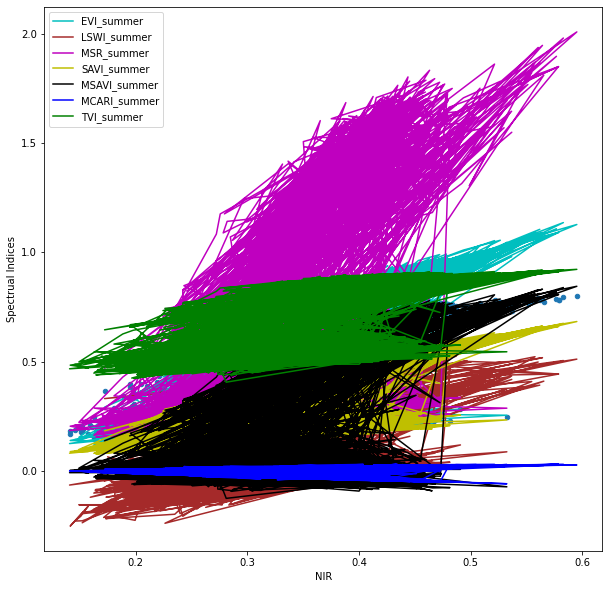

In [168]:

ax = df_uto_G.plot(kind='scatter', x='B5_summer', y='NDVI_summer', figsize=(10,10))
# df_uto_G_v2.plot(x="B5_spring",y="MSAVI_spring", color="r", ax=ax)
df_uto_G.plot(x="B5_summer",y="EVI_summer", color="c", ax=ax)
df_uto_G.plot(x="B5_summer",y="LSWI_summer", color="brown", ax=ax)
df_uto_G.plot(x="B5_summer",y="MSR_summer", color="m", ax=ax)
df_uto_G.plot(x="B5_summer",y="SAVI_summer", color="y", ax=ax)
df_uto_G.plot(x="B5_summer",y="MSAVI_summer", color="k", ax=ax)
df_uto_G.plot(x="B5_summer",y="MCARI_summer", color="b", ax=ax)
df_uto_G.plot(x="B5_summer",y="TVI_summer", color="g", ax=ax)

ax.set_xlabel("NIR")
ax.set_ylabel("Spectrual Indices")
plt.show()

# Pre-process dataset

In [183]:
# drop nan
df_uto = df_uto.dropna()


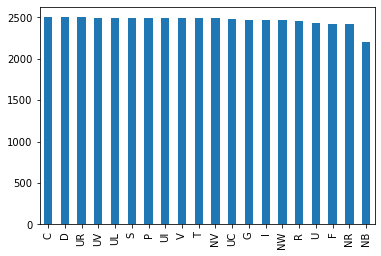

In [184]:
fig, ax = plt.subplots()
ax = df_uto['CLASS1_spring'].value_counts().plot(kind = 'bar')
plt.show()

# boxplot the indices for each crop types

<AxesSubplot:xlabel='CLASS1_spring', ylabel='NDVI_spring'>

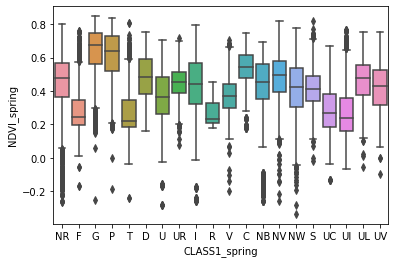

In [16]:
# approach-1:  check the effectiveness of index for one season

sns.boxplot(x='CLASS1_spring', y='NDVI_spring', data=df_uto)

<AxesSubplot:xlabel='CLASS1_spring', ylabel='LSWI_spring'>

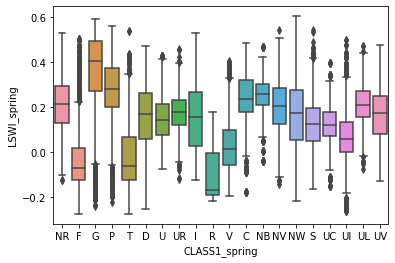

In [17]:
sns.boxplot(x='CLASS1_spring', y='LSWI_spring', data=df_uto)

<AxesSubplot:xlabel='CLASS1_spring', ylabel='NDSI_spring'>

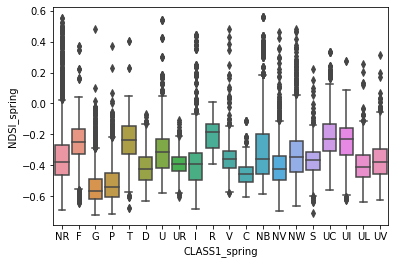

In [18]:
sns.boxplot(x='CLASS1_spring', y='NDSI_spring', data=df_uto)

In [185]:
# approach-2:  check the effectiveness of index for whole year


df_index['NDVI_average'] = df_index[['NDVI_spring','NDVI_winter','NDVI_summer']].mean(axis=1)

df_index

,CLASS1_summer,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,MSR_winter,MSR_summer,SAVI_spring,SAVI_winter,SAVI_summer,MSAVI_spring,MSAVI_winter,MSAVI_summer,MCARI_spring,MCARI_winter,MCARI_summer,TVI_spring,TVI_winter,TVI_summer,NDVI_average
4,F,0.210534,0.197296,0.230916,0.214013,0.170980,0.213174,-0.094129,-0.153338,-0.125828,-0.229956,-0.174675,-0.235657,0.238288,0.221302,0.265108,0.145942,0.117611,0.149278,0.000272,0.003661,0.028913,-0.011330,-0.009316,-0.009483,0.510425,0.497289,0.530015,0.212916
5,F,0.222991,0.181968,0.231603,0.201977,0.131768,0.178827,-0.083274,-0.152876,-0.028863,-0.189307,-0.072691,-0.143312,0.254581,0.202036,0.266026,0.135316,0.087498,0.120261,0.025567,0.002756,0.037015,-0.004007,-0.001194,-0.001800,0.522485,0.481630,0.530663,0.212187
6,F,0.212935,0.210492,0.243717,0.209315,0.174416,0.193309,-0.090101,-0.140757,-0.081628,-0.216733,-0.169497,-0.179021,0.241404,0.238233,0.282385,0.141841,0.119895,0.132724,0.008036,0.017830,0.046351,-0.008675,-0.007065,-0.003331,0.512772,0.510384,0.541956,0.222381
7,G,0.576565,0.173810,0.339820,0.621404,0.136403,0.314936,0.271397,-0.119738,0.082873,-0.539028,-0.146992,-0.375475,0.929580,0.191952,0.424597,0.429011,0.096674,0.235531,0.447856,-0.010981,0.141240,0.007766,-0.007378,-0.010813,0.791559,0.473086,0.624356,0.363398
8,G,0.629596,0.159978,0.428459,0.693901,0.121682,0.417133,0.333312,-0.118942,0.203629,-0.573296,-0.123014,-0.459664,1.097500,0.175112,0.580921,0.472231,0.085953,0.311836,0.527020,-0.019265,0.248382,0.013065,-0.006731,-0.008382,0.824376,0.458233,0.691707,0.406011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61931,G,0.702788,0.245067,0.259177,0.795828,0.196590,0.249595,0.430371,-0.148058,-0.122756,-0.586003,-0.202978,-0.330225,1.393576,0.284227,0.303725,0.510314,0.138130,0.188656,0.625997,0.047270,0.046960,0.020823,-0.006949,-0.018784,0.867634,0.543200,0.556037,0.402344
61932,G,0.622199,0.221243,0.330546,0.639973,0.173480,0.333103,0.336701,-0.145028,0.025759,-0.525418,-0.204669,-0.419639,1.072145,0.252275,0.409791,0.426294,0.126066,0.257773,0.482821,0.026894,0.124064,0.012367,-0.009530,-0.020685,0.819877,0.520809,0.616884,0.391329
61933,G,0.672294,0.196737,0.264820,0.723867,0.151665,0.264571,0.403605,-0.126715,-0.009824,-0.555727,-0.165366,-0.396307,1.258988,0.220591,0.311649,0.469755,0.108317,0.213848,0.561518,0.008147,0.033239,0.015936,-0.007715,-0.028715,0.849879,0.496726,0.561088,0.377950
61934,G,0.660623,0.212940,0.317717,0.656770,0.155878,0.306006,0.376289,-0.088162,-0.026698,-0.518722,-0.189422,-0.406092,1.212046,0.241411,0.389725,0.427160,0.115159,0.239657,0.507190,0.021812,0.111935,0.017369,-0.009555,-0.022071,0.842984,0.512777,0.606397,0.397093


<AxesSubplot:xlabel='CLASS1_spring', ylabel='NDVI_average'>

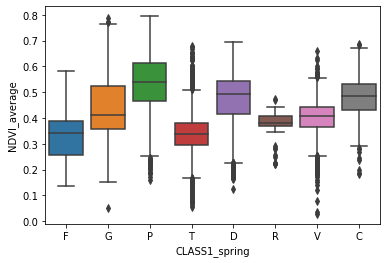

In [23]:
sns.boxplot(x='CLASS1_spring', y='NDVI_average', data=df_index)

In [13]:
df_class_target.shape

(8276, 64)

In [14]:
df_index_0 = df_class_target[df_uto.NDVI_spring > 0]
df_index_0 = df_index_0.dropna()
df_index_0

C:\Users\markc\AppData\Local\Temp/ipykernel_34620/1736795623.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_index_0 = df_class_target[df_uto.NDVI_spring > 0]


,system:index,B1_spring,B10_spring,B11_spring,B2_spring,B3_spring,B4_spring,B5_spring,B6_spring,B7_spring,B8_spring,B9_spring,CLASS1_spring,B1_winter,B10-winter,B11_winter,B2_winter,B3_winter,B4_winter,B5_winter,B6_winter,B7_winter,B8_winter,B9_winter,CLASS1_winter,B1_summer,B10_summer,B11_summer,B2_summer,B3_summer,B4_summer,B5_summer,B6_summer,B7_summer,B8_summer,B9_summer,CLASS1_summer,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,MSR_winter,MSR_summer,SAVI_spring,SAVI_winter,SAVI_summer,MSAVI_spring,MSAVI_winter,MSAVI_summer,MCARI_spring,MCARI_winter,MCARI_summer,TVI_spring,TVI_winter,TVI_summer
4,0000000000000000a7ab,0.174291,299.341827,296.964478,0.162792,0.153956,0.169576,0.260021,0.314058,0.257832,0.158310,0.007199,F,0.156139,291.498016,290.941162,0.138696,0.119764,0.132346,0.197404,0.268908,0.212049,0.122958,0.001143,F,0.158954,303.126740,301.695099,0.144171,0.132493,0.145624,0.233070,0.300166,0.230131,0.136236,0.001224,F,0.210534,0.197296,0.230916,0.214013,0.170980,0.213174,-0.094129,-0.153338,-0.125828,-0.229956,-0.174675,-0.235657,0.238288,0.221302,0.265108,0.145942,0.117611,0.149278,0.000272,0.003661,0.028913,-0.011330,-0.009316,-0.009483,0.510425,0.497289,0.530015
5,0000000000000000a8b5,0.157427,301.605499,298.911774,0.141596,0.125611,0.131975,0.207725,0.245464,0.201440,0.128418,0.007765,F,0.142115,291.878265,291.292786,0.120521,0.094496,0.096489,0.139416,0.189735,0.151276,0.095479,0.001039,F,0.142383,302.269073,300.907867,0.122151,0.100126,0.101707,0.163019,0.172709,0.112946,0.099810,0.001171,F,0.222991,0.181968,0.231603,0.201977,0.131768,0.178827,-0.083274,-0.152876,-0.028863,-0.189307,-0.072691,-0.143312,0.254581,0.202036,0.266026,0.135316,0.087498,0.120261,0.025567,0.002756,0.037015,-0.004007,-0.001194,-0.001800,0.522485,0.481630,0.530663
6,0000000000000000a8b8,0.168777,300.750458,298.205933,0.155936,0.145052,0.157183,0.242233,0.290206,0.236275,0.148758,0.007238,F,0.150223,291.505402,290.978394,0.131565,0.110931,0.120835,0.185267,0.245966,0.188893,0.113947,0.000976,F,0.142736,302.135986,300.872070,0.123408,0.103626,0.107769,0.177228,0.208733,0.139815,0.104511,0.001166,F,0.212935,0.210492,0.243717,0.209315,0.174416,0.193309,-0.090101,-0.140757,-0.081628,-0.216733,-0.169497,-0.179021,0.241404,0.238233,0.282385,0.141841,0.119895,0.132724,0.008036,0.017830,0.046351,-0.008675,-0.007065,-0.003331,0.512772,0.510384,0.541956
7,00000000000000005afd,0.133703,296.563812,294.972321,0.116205,0.118793,0.104201,0.387968,0.222333,0.136868,0.109767,0.003128,G,0.148079,291.186798,290.849060,0.128614,0.113099,0.121724,0.172940,0.219989,0.181171,0.114037,0.001239,G,0.145854,307.062012,304.706665,0.130637,0.127903,0.141770,0.287719,0.243681,0.165689,0.130560,0.001148,G,0.576565,0.173810,0.339820,0.621404,0.136403,0.314936,0.271397,-0.119738,0.082873,-0.539028,-0.146992,-0.375475,0.929580,0.191952,0.424597,0.429011,0.096674,0.235531,0.447856,-0.010981,0.141240,0.007766,-0.007378,-0.010813,0.791559,0.473086,0.624356
8,00000000000000005bc2,0.129519,295.394073,293.930420,0.110509,0.112607,0.092614,0.407458,0.203739,0.116085,0.102388,0.003120,G,0.146330,291.497711,291.154266,0.126386,0.109326,0.117201,0.161842,0.205539,0.169000,0.110224,0.001229,G,0.140792,305.151428,303.079987,0.124598,0.124675,0.134672,0.336588,0.222701,0.133007,0.125970,0.001166,G,0.629596,0.159978,0.428459,0.693901,0.121682,0.417133,0.333312,-0.118942,0.203629,-0.573296,-0.123014,-0.459664,1.097500,0.175112,0.580921,0.472231,0.085953,0.311836,0.527020,-0.019265,0.248382,0.013065,-0.006731,-0.008382,0.824376,0.458233,0.691707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61931,0001000000000000448c,0.125822,293.313995,291.521393,0.104265,0.097974,0.069

In [15]:
df_index_0.columns
df_index = df_index_0.drop(columns=['system:index','B1_spring', 'B10_spring', 'B11_spring', 'B2_spring',
       'B3_spring', 'B4_spring', 'B5_spring', 'B6_spring', 'B7_spring',
       'B8_spring', 'B9_spring', 'CLASS1_spring', 'B1_winter', 'B10-winter',
       'B11_winter', 'B2_winter', 'B3_winter', 'B4_winter', 'B5_winter',
       'B6_winter', 'B7_winter', 'B8_winter', 'B9_winter', 'CLASS1_winter',
       'B1_summer', 'B10_summer', 'B11_summer', 'B2_summer', 'B3_summer',
       'B4_summer', 'B5_summer', 'B6_summer', 'B7_summer', 'B8_summer',
       'B9_summer'])
df_index.describe()

,NDVI_spring,NDVI_winter,NDVI_summer,EVI_spring,EVI_winter,EVI_summer,LSWI_spring,LSWI_winter,LSWI_summer,NDSI_spring,NDSI_winter,NDSI_summer,MSR_spring,MSR_winter,MSR_summer,SAVI_spring,SAVI_winter,SAVI_summer,MSAVI_spring,MSAVI_winter,MSAVI_summer,MCARI_spring,MCARI_winter,MCARI_summer,TVI_spring,TVI_winter,TVI_summer
count,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000
mean,0.515245,0.313187,0.482441,0.564432,0.284764,0.534140,0.207220,0.006659,0.181723,-0.438612,-0.231564,-0.445297,0.930642,0.449132,0.802848,0.365526,0.188012,0.350126,0.383569,0.130495,0.330994,0.009474,-0.001232,0.001263,0.736678,0.586041,0.717489
std,0.209542,0.179156,0.185272,0.281295,0.213758,0.251876,0.222500,0.165371,0.192739,0.175782,0.170262,0.121258,0.564502,0.382464,0.461880,0.171985,0.128925,0.142339,0.276726,0.193487,0.244921,0.012818,0.010000,0.016316,0.150172,0.140515,0.132867
min,0.010267,-0.021397,0.066070,0.005326,-0.008327,0.074169,-0.276644,-0.370577,-0.250734,-0.721153,-0.668736,-0.694721,0.010321,-0.021173,0.068405,0.003564,-0.004918,0.044301,-0.354105,-0.258985,-0.375628,-0.034814,-0.052529,-0.057270,0.245494,0.169125,0.340691
25%,0.323604,0.174668,0.314373,0.293991,0.132378,0.305622,0.003242,-0.118474,0.014112,-0.583759,-0.354848,-0.539261,0.398874,0.193007,0.384571,0.204929,0.091678,0.231912,0.118710,-0.007529,0.108323,-0.000308,-0.008058,-0.011219,0.611231,0.473991,0.603633
50%,0.562180,0.235424,0.492012,0.591973,0.194882,0.514467,0.241444,-0.042465,0.163229,-0.483405,-0.220846,-0.456125,0.888939,0.271153,0.713798,0.387969,0.138217,0.349166,0.403259,0.035780,0.320814,0.010326,-0.002059,0.002632,0.782420,0.534251,0.736215
75%,0.701623,0.445597,0.657968,0.795406,0.397244,0.754568,0.395157,0.117526,0.359208,-0.305395,-0.115781,-0.375590,1.388082,0.614771,1.201684,0.508186,0.264739,0.471470,0.622470,0.233320,0.547618,0.020409,0.004294,0.015792,0.866962,0.703987,0.841409
max,0.846786,0.815658,0.814815,1.168279,1.096733,1.187912,0.592300,0.720568,0.570146,0.265327,0.417288,0.159724,2.471839,2.138375,2.130494,0.718992,0.644227,0.702878,0.936947,0.852740,0.870214,0.051816,0.032125,0.040613,0.946988,0.930407,0.929954


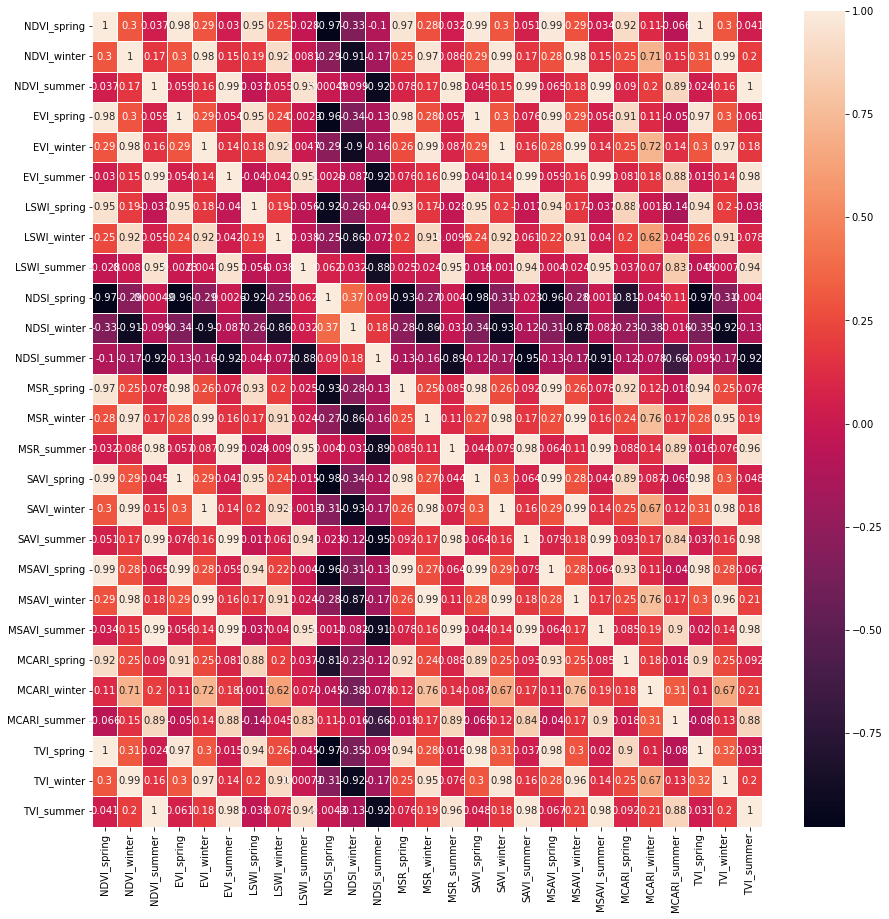

In [33]:
corrMatrix = df_index.corr()
plt.figure(figsize=(15,15))
ax = sns.heatmap(corrMatrix, annot=True, linewidths=.9)
# plt.show()

## select certain columns as features

In [16]:
df_index.columns

Index(['CLASS1_summer', 'NDVI_spring', 'NDVI_winter', 'NDVI_summer',
       'EVI_spring', 'EVI_winter', 'EVI_summer', 'LSWI_spring', 'LSWI_winter',
       'LSWI_summer', 'NDSI_spring', 'NDSI_winter', 'NDSI_summer',
       'MSR_spring', 'MSR_winter', 'MSR_summer', 'SAVI_spring', 'SAVI_winter',
       'SAVI_summer', 'MSAVI_spring', 'MSAVI_winter', 'MSAVI_summer',
       'MCARI_spring', 'MCARI_winter', 'MCARI_summer', 'TVI_spring',
       'TVI_winter', 'TVI_summer'],
      dtype='object')

In [17]:
df_index.shape

(8274, 28)

In [18]:
# df_features = df_index[[ 'NDVI_spring', 'NDVI_winter',
#        'NDVI_summer', 'EVI_spring', 'EVI_winter', 'EVI_summer', 'LSWI_spring',
#        'LSWI_winter', 'LSWI_summer', 'NDSI_spring', 'NDSI_winter',
#        'NDSI_summer', 'MSR_spring', 'SAVI_spring', 'MSAVI_spring',
#        'MCARI_spring', 'TVI_spring', 'MSR_winter', 'MSR_summer', 'SAVI_winter',
#        'SAVI_summer', 'MSAVI_winter', 'MSAVI_summer', 'MCARI_winter',
#        'MCARI_summer', 'TVI_winter', 'TVI_summer']]
# df_features

df_features = df_index[[ 'EVI_spring', 'EVI_winter', 'EVI_summer', 'MSR_spring', 'SAVI_spring', 'MSAVI_spring',
        'MSR_winter', 'MSR_summer', 'SAVI_winter',
       'SAVI_summer', 'MSAVI_winter', 'MSAVI_summer']]
df_features

,EVI_spring,EVI_winter,EVI_summer,MSR_spring,SAVI_spring,MSAVI_spring,MSR_winter,MSR_summer,SAVI_winter,SAVI_summer,MSAVI_winter,MSAVI_summer
4,0.214013,0.170980,0.213174,0.238288,0.145942,0.000272,0.221302,0.265108,0.117611,0.149278,0.003661,0.028913
5,0.201977,0.131768,0.178827,0.254581,0.135316,0.025567,0.202036,0.266026,0.087498,0.120261,0.002756,0.037015
6,0.209315,0.174416,0.193309,0.241404,0.141841,0.008036,0.238233,0.282385,0.119895,0.132724,0.017830,0.046351
7,0.621404,0.136403,0.314936,0.929580,0.429011,0.447856,0.191952,0.424597,0.096674,0.235531,-0.010981,0.141240
8,0.693901,0.121682,0.417133,1.097500,0.472231,0.527020,0.175112,0.580921,0.085953,0.311836,-0.019265,0.248382
...,...,...,...,...,...,...,...,...,...,...,...,...
61931,0.795828,0.196590,0.249595,1.393576,0.510314,0.625997,0.284227,0.303725,0.138130,0.188656,0.047270,0.046960
61932,0.639973,0.173480,0.333103,1.072145,0.426294,0.482821,0.252275,0.409791,0.126066,0.257773,0.026894,0.124064
61933,0.723867,0.151665,0.264571,1.258988,0.469755,0.561518,0.220591,0.311649,0.108317,0.213848,0.008147,0.033239
61934,0.656770,0.155878,0.306006,1.212046,0.427160,0.507190,0.241411,0.389725,0.115159,0.239657,0.021812,0.111935


In [19]:
df_target = df_index['CLASS1_summer']
df_target.value_counts()

G    2864
P    2582
T    1433
F    1065
C     279
R      51
Name: CLASS1_summer, dtype: int64

In [189]:
df_features.to_csv('features.csv', index = False)

In [190]:
df_target.to_csv('target.csv', index = False)

# split the datasets

In [20]:
# stratify=df_target

x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size = 0.2, random_state = 42#, stratify = df_target
                                                   )

In [21]:
# LabelEncoder 
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical


le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_encode = le.transform(y_train)
le.fit(y_test)
y_test_encode = le.transform(y_test)

In [22]:
print("Shape of X_train",x_train.shape)
print("Shape of X_test",x_test.shape)
y_train_mlp = to_categorical(y_train_encode, 12)
y_test_mlp = to_categorical(y_test_encode, 12)
print("Shape of y_train_mlp",y_train_mlp.shape)
print("Shape of y_test_mlp",y_test_mlp.shape)


Shape of X_train (6619, 12)
Shape of X_test (1655, 12)
Shape of y_train_mlp (6619, 12)
Shape of y_test_mlp (1655, 12)


## Neural Network  -- MLP

In [41]:
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils

In [43]:
model=Sequential()
model.add(Dense(40,input_dim=12,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dense(40,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])

model.summary()
history = model.fit(x_train,y_train_mlp,
                    validation_data=(x_test,y_test_mlp)
                    ,batch_size=400,epochs=400,verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                520       
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 40)                1640      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_7 (Dense)             (None, 12)                492       
                                                                 
Total params: 4,292
Trainable params: 4,292
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
17/17 [==============================] -

17/17 [==============================] - 0s 7ms/step - loss: 0.7654 - accuracy: 0.7219 - val_loss: 0.7776 - val_accuracy: 0.7130
Epoch 52/400
17/17 [==============================] - 0s 7ms/step - loss: 0.7613 - accuracy: 0.7214 - val_loss: 0.7766 - val_accuracy: 0.7178
Epoch 53/400
17/17 [==============================] - 0s 6ms/step - loss: 0.7610 - accuracy: 0.7243 - val_loss: 0.7764 - val_accuracy: 0.7227
Epoch 54/400
17/17 [==============================] - 0s 7ms/step - loss: 0.7580 - accuracy: 0.7216 - val_loss: 0.7740 - val_accuracy: 0.7184
Epoch 55/400
17/17 [==============================] - 0s 7ms/step - loss: 0.7552 - accuracy: 0.7223 - val_loss: 0.7728 - val_accuracy: 0.7221
Epoch 56/400
17/17 [==============================] - 0s 7ms/step - loss: 0.7529 - accuracy: 0.7275 - val_loss: 0.7711 - val_accuracy: 0.7172
Epoch 57/400
17/17 [==============================] - 0s 7ms/step - loss: 0.7532 - accuracy: 0.7231 - val_loss: 0.7690 - val_accuracy: 0.7184
Epoch 58/400
17/17 

Epoch 109/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6803 - accuracy: 0.7507 - val_loss: 0.6929 - val_accuracy: 0.7414
Epoch 110/400
17/17 [==============================] - 0s 8ms/step - loss: 0.6841 - accuracy: 0.7537 - val_loss: 0.6922 - val_accuracy: 0.7396
Epoch 111/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6796 - accuracy: 0.7498 - val_loss: 0.6904 - val_accuracy: 0.7492
Epoch 112/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6791 - accuracy: 0.7522 - val_loss: 0.6901 - val_accuracy: 0.7408
Epoch 113/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6763 - accuracy: 0.7525 - val_loss: 0.6872 - val_accuracy: 0.7492
Epoch 114/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6750 - accuracy: 0.7553 - val_loss: 0.6920 - val_accuracy: 0.7462
Epoch 115/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6765 - accuracy: 0.7540 - val_loss: 0.6865 - val_accuracy: 0.7511

17/17 [==============================] - 0s 7ms/step - loss: 0.6431 - accuracy: 0.7679 - val_loss: 0.6681 - val_accuracy: 0.7662
Epoch 167/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6443 - accuracy: 0.7654 - val_loss: 0.6619 - val_accuracy: 0.7680
Epoch 168/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6431 - accuracy: 0.7681 - val_loss: 0.6639 - val_accuracy: 0.7674
Epoch 169/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6418 - accuracy: 0.7688 - val_loss: 0.6654 - val_accuracy: 0.7662
Epoch 170/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6464 - accuracy: 0.7654 - val_loss: 0.6643 - val_accuracy: 0.7644
Epoch 171/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6460 - accuracy: 0.7649 - val_loss: 0.6657 - val_accuracy: 0.7601
Epoch 172/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6422 - accuracy: 0.7657 - val_loss: 0.6647 - val_accuracy: 0.7595
Epoch 173/400

17/17 [==============================] - 0s 7ms/step - loss: 0.6325 - accuracy: 0.7670 - val_loss: 0.6557 - val_accuracy: 0.7674
Epoch 224/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6267 - accuracy: 0.7702 - val_loss: 0.6555 - val_accuracy: 0.7625
Epoch 225/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6297 - accuracy: 0.7682 - val_loss: 0.6593 - val_accuracy: 0.7571
Epoch 226/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6299 - accuracy: 0.7699 - val_loss: 0.6535 - val_accuracy: 0.7680
Epoch 227/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6305 - accuracy: 0.7725 - val_loss: 0.6517 - val_accuracy: 0.7686
Epoch 228/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6300 - accuracy: 0.7690 - val_loss: 0.6500 - val_accuracy: 0.7680
Epoch 229/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6279 - accuracy: 0.7710 - val_loss: 0.6584 - val_accuracy: 0.7644
Epoch 230/400

17/17 [==============================] - 0s 6ms/step - loss: 0.6164 - accuracy: 0.7738 - val_loss: 0.6470 - val_accuracy: 0.7716
Epoch 281/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6149 - accuracy: 0.7716 - val_loss: 0.6483 - val_accuracy: 0.7698
Epoch 282/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6159 - accuracy: 0.7767 - val_loss: 0.6481 - val_accuracy: 0.7764
Epoch 283/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6152 - accuracy: 0.7753 - val_loss: 0.6492 - val_accuracy: 0.7698
Epoch 284/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6147 - accuracy: 0.7749 - val_loss: 0.6469 - val_accuracy: 0.7680
Epoch 285/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6112 - accuracy: 0.7763 - val_loss: 0.6499 - val_accuracy: 0.7734
Epoch 286/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6120 - accuracy: 0.7767 - val_loss: 0.6486 - val_accuracy: 0.7734
Epoch 287/400

17/17 [==============================] - 0s 7ms/step - loss: 0.6033 - accuracy: 0.7820 - val_loss: 0.6463 - val_accuracy: 0.7710
Epoch 338/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6036 - accuracy: 0.7782 - val_loss: 0.6513 - val_accuracy: 0.7698
Epoch 339/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6023 - accuracy: 0.7800 - val_loss: 0.6467 - val_accuracy: 0.7734
Epoch 340/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6058 - accuracy: 0.7812 - val_loss: 0.6457 - val_accuracy: 0.7722
Epoch 341/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6064 - accuracy: 0.7805 - val_loss: 0.6462 - val_accuracy: 0.7692
Epoch 342/400
17/17 [==============================] - 0s 6ms/step - loss: 0.6046 - accuracy: 0.7782 - val_loss: 0.6434 - val_accuracy: 0.7716
Epoch 343/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6048 - accuracy: 0.7782 - val_loss: 0.6448 - val_accuracy: 0.7704
Epoch 344/400

17/17 [==============================] - 0s 7ms/step - loss: 0.5943 - accuracy: 0.7843 - val_loss: 0.6399 - val_accuracy: 0.7734
Epoch 395/400
17/17 [==============================] - 0s 7ms/step - loss: 0.5951 - accuracy: 0.7820 - val_loss: 0.6420 - val_accuracy: 0.7722
Epoch 396/400
17/17 [==============================] - 0s 7ms/step - loss: 0.5943 - accuracy: 0.7821 - val_loss: 0.6447 - val_accuracy: 0.7734
Epoch 397/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6001 - accuracy: 0.7794 - val_loss: 0.6486 - val_accuracy: 0.7674
Epoch 398/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6005 - accuracy: 0.7835 - val_loss: 0.6434 - val_accuracy: 0.7728
Epoch 399/400
17/17 [==============================] - 0s 7ms/step - loss: 0.6036 - accuracy: 0.7806 - val_loss: 0.6456 - val_accuracy: 0.7740
Epoch 400/400
17/17 [==============================] - 0s 7ms/step - loss: 0.5945 - accuracy: 0.7862 - val_loss: 0.6442 - val_accuracy: 0.7716


52/52 [==============================] - 0s 2ms/step
Accuracy of the MLP model 77.16012084592145


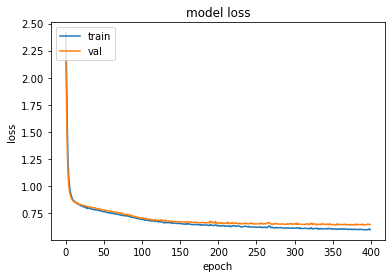

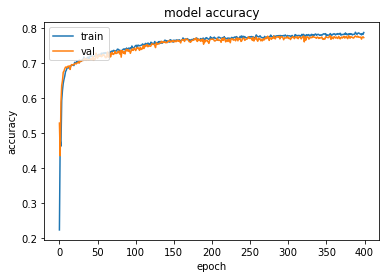

In [44]:
##################################################
prediction=model.predict(x_test)
length=len(prediction)
y_label=np.argmax(y_test_mlp,axis=1)
predict_label=np.argmax(prediction,axis=1)
accuracy=np.sum(y_label==predict_label)/length * 100 
print("Accuracy of the MLP model",accuracy )

################Model Loss#########################
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
##################################################
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# build Random Forest Tree

In [23]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, y_train)

y_preds_rf = rf.predict(x_test)

# accuracy on test
print("Training Accuracy is:", rf.score(x_train,y_train))
print("Test Accuracy is:", rf.score(x_test, y_test))

Training Accuracy is: 1.0
Test Accuracy is: 0.760725075528701


In [25]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt


In [44]:
# learning curve --overfitting
decision_tree = RandomForestClassifier(random_state=0)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=decision_tree,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

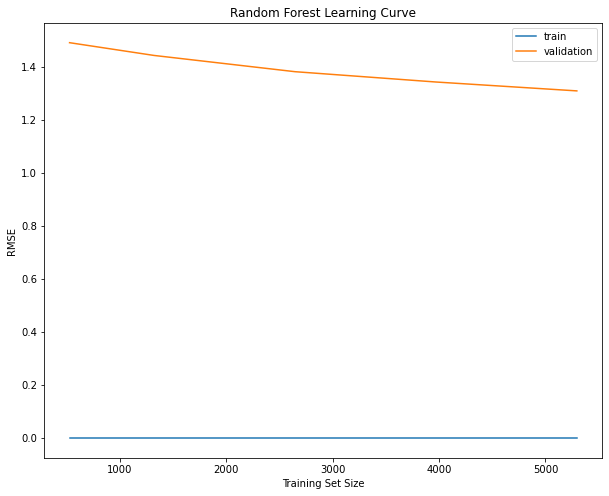

In [45]:
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Random Forest Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

# observation:'The model makes very few mistakes when it's required to predict instances it's seen during training, but performs terribly on new instances it hasn't been exposed to. You can observe this behavior by noticing how large the generalization error is between the training curve and the validation curve. A solution to improve this behavior may be to add more instances to our training dataset which introduces bias. Another solution may be to add regularization to the model (i.e. restricting the tree from growing to its full depth).'

In [62]:
# check the parameters of the model
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

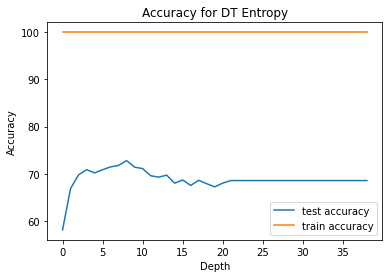

In [63]:
# build decision tree with different depths

list_entro = []
list_train_rf = []
for i in range(1,40):
    c1_entropy_loop = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    c1_entropy_loop.fit(x_train,y_train)

    pred_entropy_loop = c1_entropy_loop.predict(x_test)
    acc_test = accuracy_score(pred_entropy_loop, y_test)*100
    acc_train = rf.score(x_train,y_train)
    list_train_rf.append(acc_train)
    list_entro.append(acc_test)
#     print('Accuracy for Entropy at depth', i, ':', acc)

list_depth = range(20)
plt.plot(list_entro, label = "test accuracy")
plt.plot(np.array(list_train_rf) * 100, label = "train accuracy")
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for DT Entropy')
plt.legend()
plt.show()

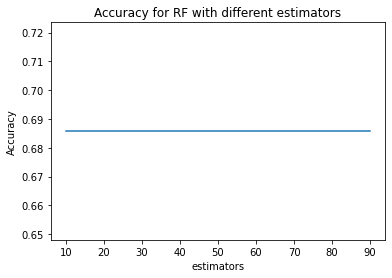

In [65]:
# tune estimator in RF

estimators = [10,30,50,70,90]
accs = []

for i in estimators:
    rf = RandomForestClassifier(random_state=0, n_estimators = i)
    rf.fit(x_train,y_train)

    pred_rf= rf.predict(x_test)
    acc = accuracy_score(pred_entropy_loop, y_test)
    accs.append(acc)
#     print('Accuracy for RF at estimator', i, ':', acc)

plt.plot(estimators, accs)
plt.xlabel('estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy for RF with different estimators')
plt.show()

In [72]:
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
max_features = ['auto', 'sqrt']
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
criterion=['gini', 'entropy']

In [73]:
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [75]:
from sklearn.model_selection import RandomizedSearchCV
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\markc\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.76703375 0.7550985  0.76386131 0.76235177 0.76371071 0.7198963
 0.76507046 0.76129334 0.75948054 0.72155759 0.76401317 0.72216239
        nan 0.7652198  0.58347252 0.58362369 0.76431494 0.72261534
        nan 0.72216182 0.7652214  0.76627835 0.765372   0.76053782
 0.76129311        nan 0.76763798 0.75298381 0.72170945 0.7661282 ]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [80]:
print(rf_random.best_params_)
print(rf_random.score(x_train, y_train))
print(rf_random.score(x_test, y_test ))

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': True}
0.9770358060129929
0.7595166163141994


In [81]:
decision_tree = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 2, max_depth = 100, criterion = 'entropy', bootstrap= True)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=decision_tree,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

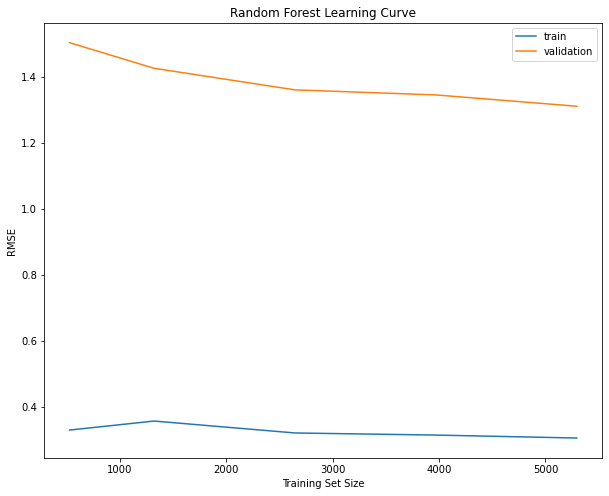

In [82]:
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Random Forest Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()


In [66]:
# check the feature importance of RF
# select top 10 important features

rf_feature = RandomForestClassifier(random_state=0, n_estimators=200)
rf_feature.fit(x_train,y_train)

feature_importances = pd.DataFrame(rf_feature.feature_importances_, index=x_train.columns,
                                  columns=['importance']).sort_values('importance',ascending=True)

feature_importances

,importance
MSAVI_summer,0.053325
EVI_summer,0.054471
SAVI_summer,0.054711
MSR_summer,0.055812
MSR_spring,0.082135
MSR_winter,0.087136
MSAVI_spring,0.090370
EVI_spring,0.091860
SAVI_spring,0.105306
EVI_winter,0.105782


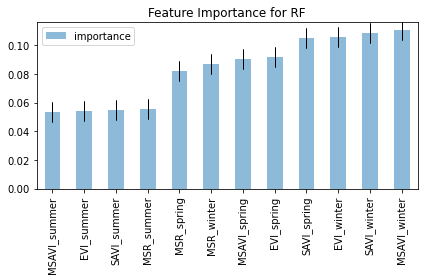

In [67]:
std = np.std([rf_feature.feature_importances_ for tree in rf_feature.estimators_], axis=0)
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax, xerr=std,align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title('Feature Importance for RF')
fig.tight_layout()

## build AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostRegressor
rng = np.random.RandomState(1)

boost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=10), random_state=rng)

boost.fit(x_train,y_train_encode)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  random_state=RandomState(MT19937) at 0x20FBD2A9040)

In [27]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=boost,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

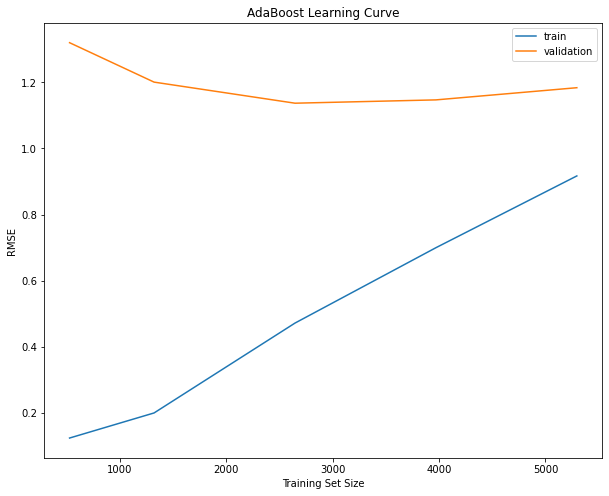

In [28]:
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("AdaBoost Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()


In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50,100,150,200],
    'learning_rate': [0.01, 0.1, 1, 10],
    'base_estimator__max_depth': [1, 2, 3,4],
}
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [40]:
grid_search_ada = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', cv=5)
grid_search_ada.fit(x_train, y_train_encode)

print(grid_search_ada.best_params_)
print(grid_search_ada.best_score_)

{'base_estimator__max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100}
0.7221610228515709


In [111]:
rng = np.random.RandomState(1)

boost_v2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=100), n_estimators=50, learning_rate = 0.05, random_state=rng)

boost_v2.fit(x_train,y_train_encode)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=100),
                  learning_rate=0.05,
                  random_state=RandomState(MT19937) at 0x1B2BD921240)

In [112]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=boost_v2,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

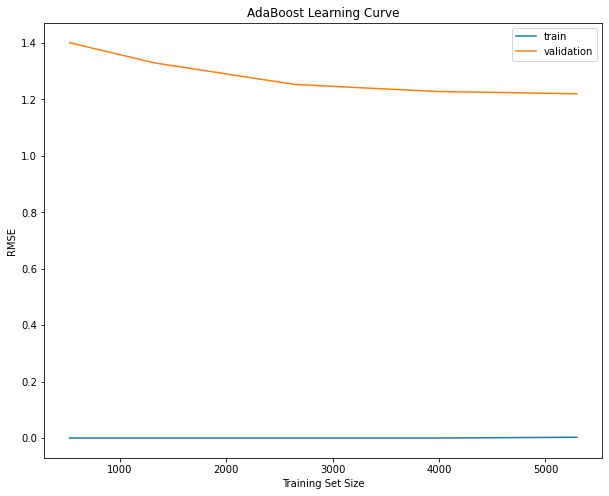

In [113]:
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("AdaBoost Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

# build SVM

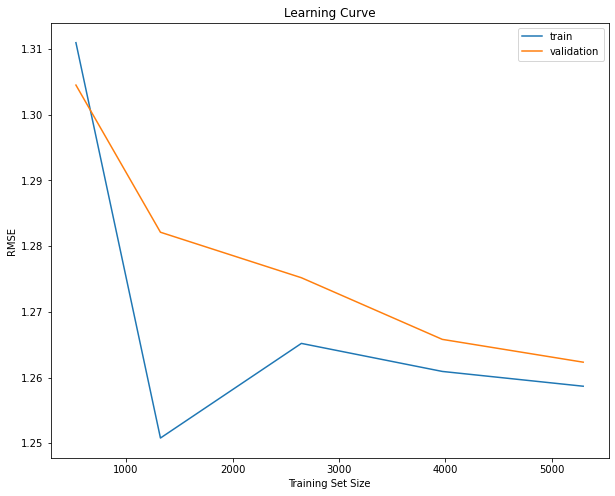

In [49]:
from sklearn.svm import SVR

svm = SVR(C=0.25)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svm,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

# observation
# 'The generalization gap for the training and validation curve becomes extremely small as the training dataset size increases. This indicates that adding more examples to our model is not going to improve its performance. A solution to this problem may be to create more features or to make the model more flexible to reduce the number of assumptions being made.'

In [97]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

param_range = np.arange(0,2, 0.3)
train_scores, test_scores = validation_curve(
    SVC(),
    X=x_train,
    y=y_train_encode,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy"
    
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

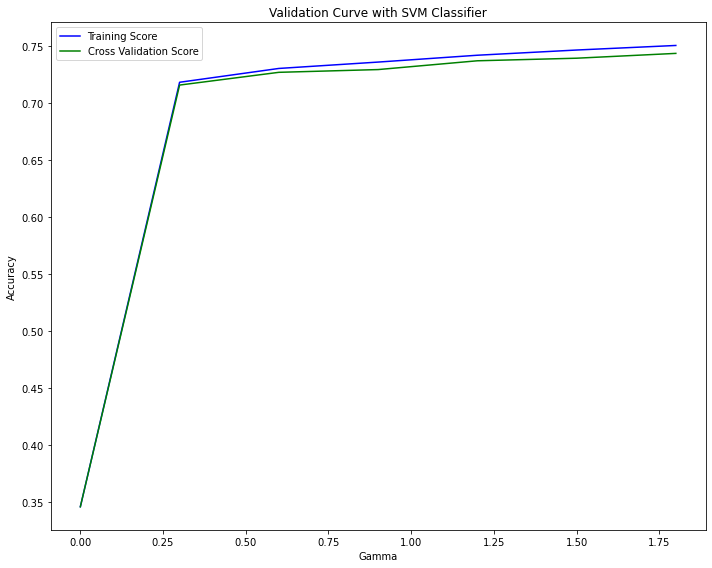

In [98]:
# Plot mean accuracy scores for training and testing scores
plt.subplots(figsize=(10,8))
plt.plot(param_range, train_scores_mean,
     label = "Training Score", color = 'b')
plt.plot(param_range, test_scores_mean,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with SVM Classifier")
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

# observation
# A plot of learning curves shows a good fit if:

# The plot of training loss decreases to a point of stability.
# The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

In [93]:
param_range =np.arange(1,1778, 200)
train_scores, test_scores = validation_curve(
    SVC(),
    X=x_train,
    y=y_train_encode,
    param_name="C",
    param_range=param_range,
    scoring="accuracy"
    
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

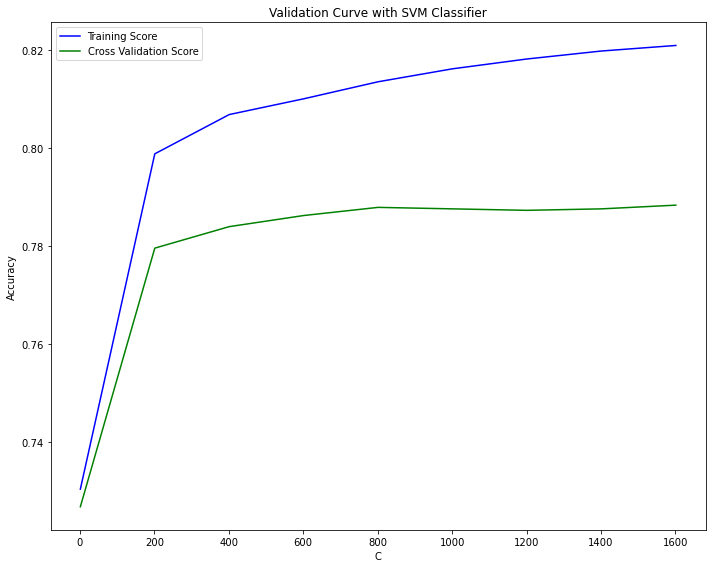

In [96]:
# Plot mean accuracy scores for training and testing scores
plt.subplots(figsize=(10,8))
plt.plot(param_range, train_scores_mean,
     label = "Training Score", color = 'b')
plt.plot(param_range, test_scores_mean,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with SVM Classifier")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [91]:
np.logspace(-9, 3, 5)

array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03])

In [47]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 5, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid_svm.fit(x_train,y_train_encode)



GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 5.62341325e-01, 3.16227766e+01, 1.77827941e+03,
       1.00000000e+05]),
                         'gamma': array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03])})

In [48]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid_svm.best_params_, grid_svm.best_score_)
)

The best parameters are {'C': 1778.2794100389228, 'gamma': 1.0} with a score of 0.79


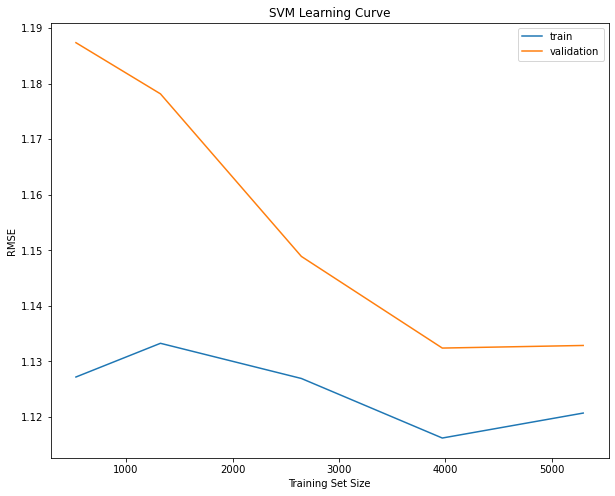

In [50]:
from sklearn.svm import SVR

svm_2 = SVR(C=200, gamma = 0.25)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svm_2,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("SVM Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

# build knn

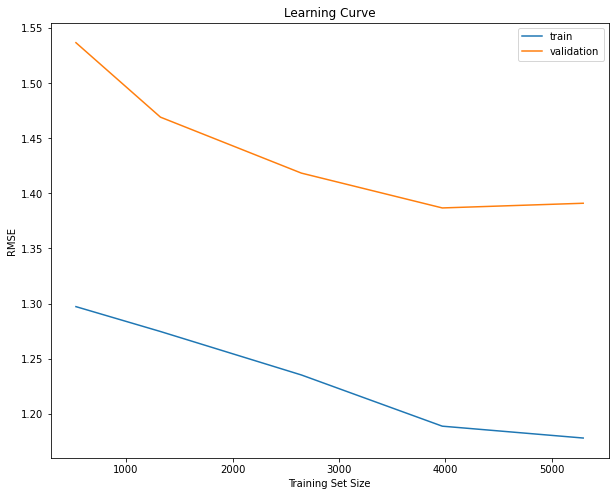

In [55]:
knn = KNeighborsClassifier(n_neighbors = 6)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("KNN Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

In [56]:
acc_list =[]

for i in range (3,11):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(x_train,y_train)
    y_preds = knn_model.predict(x_test)
    acc = knn_model.score(x_test,y_test)
    acc_list.append(acc)

[0.7299093655589124, 0.7293051359516616, 0.7395770392749245, 0.7462235649546828, 0.7395770392749245, 0.7444108761329306, 0.7395770392749245, 0.7425981873111782]


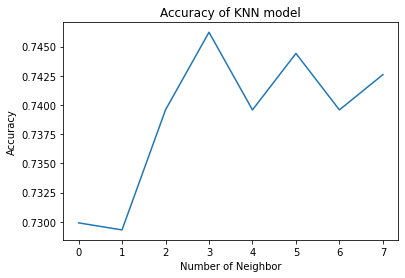

In [57]:
print(acc_list)

plt.plot(acc_list)
plt.xlabel('Number of Neighbor')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN model')
plt.show()

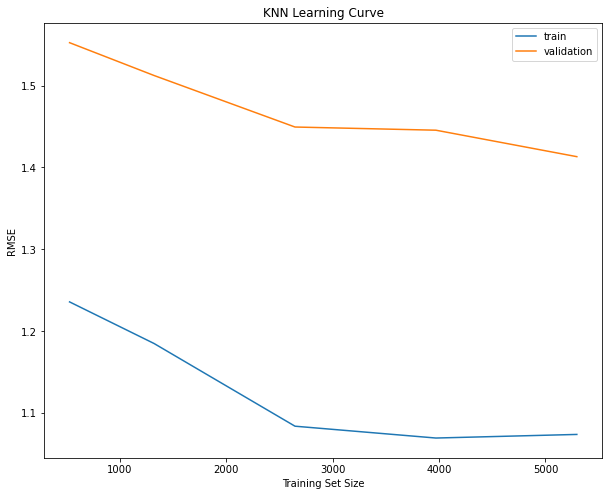

In [100]:
knn = KNeighborsClassifier(n_neighbors = 3)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn,
    X=x_train,
    y=y_train_encode,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [0.1, 0.25, 0.5, 0.75, 1]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("KNN Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")

plt.show()

# 后面是以前做的

In [101]:
# check the probability of the point falling into each catagogy
rf.predict_proba(x_test)

array([[0.177, 0.   , 0.002, ..., 0.111, 0.081, 0.037],
       [0.123, 0.   , 0.   , ..., 0.009, 0.014, 0.723],
       [0.012, 0.009, 0.106, ..., 0.202, 0.21 , 0.026],
       ...,
       [0.06 , 0.003, 0.023, ..., 0.13 , 0.613, 0.021],
       [0.072, 0.028, 0.005, ..., 0.004, 0.027, 0.149],
       [0.   , 0.   , 0.018, ..., 0.   , 0.008, 0.   ]])

In [100]:
accuracy_score(y_test, y_preds_rf)

0.5933195965730398

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds_rf))


              precision    recall  f1-score   support

           C       0.67      0.42      0.51        62
           F       0.63      0.58      0.60       211
           G       0.82      0.86      0.84       573
           P       0.82      0.82      0.82       516
           R       1.00      0.27      0.43        11
           T       0.65      0.68      0.67       282

    accuracy                           0.76      1655
   macro avg       0.76      0.61      0.64      1655
weighted avg       0.76      0.76      0.76      1655



# Tune the RF model

In [112]:
from itertools import product

n_estimators = 200
max_features = [1,'sqrt','log2']
max_depths = [None,5,10,15]
max_leaf_nodes = [None,2,5,10]
feature_list = []
depth_list = []
accuracy_list = []

for f, d, l in product(max_features,max_depths,max_leaf_nodes):
    rf_tune = RandomForestClassifier(n_estimators = 100,
                                    criterion='entropy',
                                    max_features = f,
                                    max_depth = d,
                                    max_leaf_nodes = l,
                                    random_state = 2)
    rf_tune.fit(x_train, y_train)
    pred_test = rf_tune.predict(x_test)
    accuracy_sco = accuracy_score(y_test,pred_test)
    
    feature_list.append(f)
    depth_list.append(d)
    accuracy_list.append(accuracy_sco)
    

In [113]:
pd.DataFrame(list(zip(feature_list, depth_list, accuracy_list)),
            columns=['feature_list','depth_list', 'accuracy_list'])

,feature_list,depth_list,accuracy_list
0,1,NaN,0.771866
1,1,NaN,0.442795
2,1,NaN,0.575474
3,1,NaN,0.646723
4,1,5.0,0.670701
5,1,5.0,0.442795
6,1,5.0,0.575474
7,1,5.0,0.640557
8,1,10.0,0.726878
9,1,10.0,0.442795


# XGboost with grid search -- round 1

In [115]:
# label encoding of label column

ytrain = y_train.astype('category')
y_train_cat = ytrain.cat.codes

ytest = y_test.astype('category')
y_test_cat = ytest.cat.codes

y_train_cat

system:index
000100000000000038f8    7
0000000000000000c57a    2
7236                    6
00000000000000007ca5    6
0000000000000000b7b1    3
                       ..
0000000000000000982d    1
00000000000000009a8b    4
000100000000000012b7    7
000000000000000054f6    4
000100000000000040ba    7
Length: 17516, dtype: int8

In [116]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost
# from xgboost.xgbclassifier import XGBClassifier

classifier = xgboost.XGBClassifier()

params = {
    'learning_rate':[0.05,0.1,0.15,0.2,0.25],
    'max_depth':[2,5,8,10,15,20],
    'min_child_weight':[1,3,5,7],
    'gamma':[0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree':[0.3,0.4,0.5,0.7]
}

clf_xgboost = RandomizedSearchCV(classifier, param_distributions=params,n_iter=5,scoring='roc_auc', cv=5, verbose=3)


clf_xgboost.fit(x_train,y_train_cat)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=20, min_child_weight=5;, score=nan total time=  13.2s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=20, min_child_weight=5;, score=nan total time=  10.8s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=20, min_child_weight=5;, score=nan total time=  10.9s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=20, min_child_weight=5;, score=nan total time=  10.8s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=20, min_child_weight=5;, score=nan total time=  11.4s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=20, min_child_weight=7;, score=nan total time=  12.2s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=20, min_child_weight=7;, score=nan total time=  12.2s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=20, min_child_weight=7;, score=nan total time=  12.2s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=20, min_child_weight=7;, score=nan total time=  12.2s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.2, max_depth=20, min_child_weight=7;, score=nan total time=  12.4s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=20, min_child_weight=7;, score=nan total time=  10.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=20, min_child_weight=7;, score=nan total time=  10.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=20, min_child_weight=7;, score=nan total time=  10.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=20, min_child_weight=7;, score=nan total time=  10.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=20, min_child_weight=7;, score=nan total time=  10.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=20, min_child_weight=3;, score=nan total time=  11.9s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=20, min_child_weight=3;, score=nan total time=  11.7s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=20, min_child_weight=3;, score=nan total time=  11.7s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=20, min_child_weight=3;, score=nan total time=  11.5s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=20, min_child_weight=3;, score=nan total time=  12.0s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=2, min_child_weight=1;, score=nan total time=   2.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=2, min_child_weight=1;, score=nan total time=   2.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=2, min_child_weight=1;, score=nan total time=   2.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=2, min_child_weight=1;, score=nan total time=   2.1s


C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\download\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=2, min_child_weight=1;, score=nan total time=   2.1s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=

In [117]:
clf_xgboost.best_params_

{'min_child_weight': 5,
 'max_depth': 20,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [118]:
clf_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [122]:
final_model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
               monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0)


In [123]:
final_model.fit(x_train,y_train_cat)

pred_xgboost = final_model.predict(x_test)

accuracy_score(y_test_cat,pred_xgboost)

0.7819136789221284

# round 2 -- further explore based on first round

In [415]:
classifier = xgboost.XGBClassifier()

params = {
    'learning_rate':[0.2],
    'max_depth':[5],
    'min_child_weight':[7,10,13,15],
    'gamma':[0.0],
    'colsample_bytree':[0.05,0.1,0.2,0.3],
    'scale_pos_weight':[1,3,5],
    'reg_lambda':[0,0.25,0.5,1]
}

clf_xgboost_v2 = RandomizedSearchCV(classifier, param_distributions=params,n_iter=5,scoring='roc_auc', cv=5, verbose=3)


clf_xgboost_v2.fit(x_train,y_train_cat)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0.5, scale_pos_weight=3;, score=nan total time=   6.4s
[20:27:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0.5, scale_pos_weight=3;, score=nan total time=   6.6s
[20:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0.5, scale_pos_weight=3;, score=nan total time=   6.6s
[20:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0.5, scale_pos_weight=3;, score=nan total time=   6.6s
[20:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0.5, scale_pos_weight=3;, score=nan total time=   6.6s
[20:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.2, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.2s
[20:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.2, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.1s
[20:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.2, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.2s
[20:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.2, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.2s
[20:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.2, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.2s
[20:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   7.1s
[20:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   7.0s
[20:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   7.1s
[20:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   7.0s
[20:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   7.1s
[20:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   6.7s
[20:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   6.7s
[20:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   6.6s
[20:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   6.6s
[20:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=15, reg_lambda=1, scale_pos_weight=5;, score=nan total time=   6.7s
[20:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=13, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.9s
[20:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=13, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.8s
[20:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=13, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.8s
[20:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=13, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.8s
[20:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\download\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=13, reg_lambda=0, scale_pos_weight=1;, score=nan total time=   6.8s
[20:30:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [416]:
clf_xgboost_v2.best_params_

{'scale_pos_weight': 3,
 'reg_lambda': 0.5,
 'min_child_weight': 15,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [ ]:
# use the optimized parameters based on round 1 & 2

In [417]:
clf_xgboost_v3 = xgboost.XGBClassifier(objective='binary:logistic',seed=42,
                                  min_child_weight=17,
                                  max_depth=5,
                                  learning_rate=0.2,
                                  gamma = 0,
                                  colsample_bytree = 0.3,
                                  scale_pos_weight = 3,
                                  reg_lambda = 0.5)

clf_xgboost_v3.fit(x_train,y_train_cat,verbose=True,
                  early_stopping_rounds=10,
                  eval_metric='aucpr',
                  eval_set=[(x_test,y_test_cat)])

[21:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.41258
[1]	validation_0-aucpr:0.45290


C:\download\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\download\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-aucpr:0.45651
[3]	validation_0-aucpr:0.48764
[4]	validation_0-aucpr:0.50141
[5]	validation_0-aucpr:0.51595
[6]	validation_0-aucpr:0.54169
[7]	validation_0-aucpr:0.54203
[8]	validation_0-aucpr:0.54582
[9]	validation_0-aucpr:0.55961
[10]	validation_0-aucpr:0.56821
[11]	validation_0-aucpr:0.56789
[12]	validation_0-aucpr:0.58440
[13]	validation_0-aucpr:0.59643
[14]	validation_0-aucpr:0.59927
[15]	validation_0-aucpr:0.59615
[16]	validation_0-aucpr:0.59699
[17]	validation_0-aucpr:0.59780
[18]	validation_0-aucpr:0.60121
[19]	validation_0-aucpr:0.60004
[20]	validation_0-aucpr:0.60529
[21]	validation_0-aucpr:0.60453
[22]	validation_0-aucpr:0.60555
[23]	validation_0-aucpr:0.61047
[24]	validation_0-aucpr:0.61282
[25]	validation_0-aucpr:0.62021
[26]	validation_0-aucpr:0.62299
[27]	validation_0-aucpr:0.62779
[28]	validation_0-aucpr:0.62705
[29]	validation_0-aucpr:0.63383
[30]	validation_0-aucpr:0.63639
[31]	validation_0-aucpr:0.63620
[32]	validation_0-aucpr:0.63624
[33]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=17,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

# another way to train XGBppst

In [114]:
clf_xgb = xgboost.XGBClassifier(objective='binary:logistic',missing=None,seed=42)
clf_xgb.fit(x_train,
           y_train_cat,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(x_test,y_test_cat)])

NameError: name 'xgboost' is not defined

In [ ]:
# see how it performs on the testing dataset by running the testing dataset 
# down the model and drawing a confusion matrix

In [413]:
plot_confusion_matrix(clf_xgb, x_test, y_test_cat)

XGBoostError: [20:15:34] c:\users\administrator\workspace\xgboost-win64_release_1.6.0\src\c_api\c_api_utils.h:159: Invalid missing value: null

# Ensemble model

In [62]:
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression

Tune SVM

In [74]:
# svm model with linear kernel

svc_li = svm.SVC(kernel='linear', C=1)
svc_fit_li = svc_li.fit(x_train,y_train)

y_pred = svc_fit_li.predict(x_test)
svc_score_li = svc_fit_li.score(x_test, y_test)
print(svc_score_li)

0.4130718954248366


In [71]:
# svm model with 'rbf' kernel

svc_rbf = svm.SVC(kernel='rbf', C=1)
svc_fit_rbf = svc_rbf.fit(x_train,y_train)

y_pred = svc_fit_rbf.predict(x_test)
svc_score_rbf = svc_fit_rbf.score(x_test, y_test)
print(svc_score_rbf)

0.4530920060331825


In [73]:
# svm model with 'rbf' kernel

svc_poly = svm.SVC(kernel='poly', C=1)
svc_fit_poly = svc_poly.fit(x_train,y_train)

y_pred = svc_fit_poly.predict(x_test)
svc_score_poly = svc_fit_poly.score(x_test, y_test)
print(svc_score_poly)

0.43730517848164907


Tune Logistic

In [75]:
# logistic regression model

lr = LogisticRegression(solver='liblinear', random_state=1)
lr_fit = lr.fit(x_train,y_train)

lr_score = lr_fit.score(x_test, y_test)
print(lr_score)

0.3822021116138763


In [76]:
# ensemble classifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score


ensemble_1 = VotingClassifier(estimators=[('lr',lr),('svc',svc_rbf),('rf',rf)],voting='soft')

In [77]:
ensemble_1_fit = ensemble_1.fit(x_train,y_train)

KeyboardInterrupt: 

In [53]:
# ensemble score

ensem_sco = cross_val_score(ensemble_1, x_test, y_test).mean()

C:\download\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\download\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "C:\download\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\download\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\download\lib\site-packages\sklearn\ensemble\_voting.py", line 309, in predict
    maj = np.argmax(self.predict_proba(X), axis=1)
  File "C:\download\lib\site-packages\sklearn\ensemble\_v

In [54]:
print(ensem_sco)

nan


In [79]:
from sklearn.naive_bayes import GaussianNB 
from sklearn import model_selection

clf1 = LogisticRegression(random_state=1)
clf2 = svm.SVC(kernel='linear', C=1, probability=True)
clf3 = GaussianNB()
clf4 = RandomForestClassifier(random_state=0)

print('5-fold cross validation:\n')

labels = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes','Random Forest']

for clf, label in zip([clf1, clf2, clf3, clf4], labels):

    scores = model_selection.cross_val_score(clf, x_train,y_train,
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:



C:\download\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\download\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Accuracy: 0.38 (+/- 0.00) [Logistic Regression]
Accuracy: 0.40 (+/- 0.00) [Support Vector Machine]
Accuracy: 0.30 (+/- 0.00) [Naive Bayes]
Accuracy: 0.68 (+/- 0.00) [Random Forest]


In [78]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf4], voting='soft', weights=[1,1,15])

labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest', 'Ensemble']
for clf, label in zip([clf1, clf2, clf4, eclf], labels):

    scores = model_selection.cross_val_score(clf, x_train,y_train,
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

NameError: name 'clf1' is not defined

In [ ]:
AttributeError: predict_proba is not available when  probability=False